# Segundo intento del etiquetado v2
Tras llevar a cabo el primer intento, hemos podido apreciar que los datos que aparecían en el aula virtual de moodle de la asignatura relativa a ese curso, no cuadraban con los datos calculados. Por lo tanto, tras explorar más en profundidad los datos que tenemos, y detectar las causas de los errores, vamos a volver a calcular las etiquetas. 

## Configuración del entorno


In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, concat_ws, count, avg, coalesce, to_date, from_unixtime, sum as sparkSum
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import display
import os


#  Crear sesión Spark
spark = SparkSession.builder \
    .appName("EvaluacionContinuaIP") \
    .getOrCreate()

#  Rutas base
PATH_INTERMEDIATE_STD = "/home/carlos/Documentos/TFG/spark-workspace/data/intermediate/estandarizados"
PATH_RESULTADOS = "/home/carlos/Documentos/TFG/spark-workspace/data/etiquetas"

# Crear carpeta de resultados si no existe (opcional en local)
os.makedirs(PATH_RESULTADOS, exist_ok=True)

# Verificación
print("✔️ Spark configurado y rutas preparadas.")


✔️ Spark configurado y rutas preparadas.


## Carga y visualización de datos 

In [25]:
df_entregas_tareas = spark.read.parquet(f"{PATH_INTERMEDIATE_STD}/assign_std.parquet")
df_entregas_tareas.printSchema()
df_entregas_tareas.show(5, truncate = False)

# Verificar que solo hay un registro por alumno y tarea
df_entregas_tareas.groupBy("userid", "actividad_codigo").count().filter(col("count") > 1).show()

# Verificar tareas  
df_entregas_tareas.select("actividad_codigo", "actividad_nombre", "fecha_limite").distinct().orderBy("fecha_limite").show(20, truncate = False)

# Verficar cantidad de alumnos
df_entregas_tareas.select("userid").distinct().count()
print(f"Cantidad de alumnos: {df_entregas_tareas.select('userid').distinct().count()}")


root
 |-- userid: string (nullable = true)
 |-- actividad_id: long (nullable = true)
 |-- actividad_nombre: string (nullable = true)
 |-- actividad_codigo: string (nullable = true)
 |-- fecha_limite: date (nullable = true)
 |-- nota: double (nullable = true)
 |-- entregado: integer (nullable = true)
 |-- fecha_entrega: date (nullable = true)

+----------------------------------------------------------------+------------+--------------------+----------------+------------+----+---------+-------------+
|userid                                                          |actividad_id|actividad_nombre    |actividad_codigo|fecha_limite|nota|entregado|fecha_entrega|
+----------------------------------------------------------------+------------+--------------------+----------------+------------+----+---------+-------------+
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|107688      |Entrega actividad 07|assign_107688   |2023-11-20  |6.0 |1        |2023-11-20   |
|433f2e41671277

## Verificación de datos de entregas del aula virtual 

### Datos de entregas

Antes de comenzar a calcular los abandonos en base a las entregas del proyecto, vamos a ver de forma general los datos calculados sobre entregas de los proyectos, para verificar que encajen con los datos del aula virtual


In [7]:
# 5. Exploración de los resultados

print("Exploración de resultados de TODAS las tareas assign:")
print("===========================================")
num_alumnos_distintos = df_entregas_tareas.select("userid").distinct().count()
print(f"Hay {num_alumnos_distintos} alumnos distintos en la tabla completa, cuadran los valores con los datos de alumnos matriculados de la asignatura\n")
# print(f"Cantidad de entregas marcadas como no realizadas: {df_entregas_tareas.filter(col('entregado') == 0).count()}")
# print(f"Cantidad de entregas con nota -1.00: {df_entregas_tareas.filter(col('nota') == -1.00).count()}\n")

# print("Assigns que tienen entregas marcadas como no entregadas:")
# df_entregas_tareas.filter(col('entregado') == 0).select("actividad_id", "actividad_nombre").distinct().show(100, truncate=False)

print("Exploración de resultados de la actividad 07")
print("===========================================")

# print("Notas distintas que han sido asignadas a las entregas de la actividad 07:")
# df_entregas_tareas.filter(col("actividad_id") == 107688).select("nota").distinct().show(100, truncate=False)

# print("Fechas de entrega y limite de las entregas de la actividad 07 que fueron marcadas con un -1.00:")
# df_entregas_tareas.filter((col('nota') == -1.00) & (col("actividad_id") == 107688 )).select("actividad_id", "fecha_entrega", "fecha_limite").show(100, truncate=False)

num_not_menosuno = df_entregas_tareas.filter((col('nota') != -1.00) & (col("actividad_id") == 107688 )).count()
print(f"Hay {num_not_menosuno} entregas de la actividad 07 marcadas con una nota distinta de -1.00")

num_menosuno = df_entregas_tareas.filter((col('nota') == -1.00) & (col("actividad_id") == 107688 )).count()
print(f"Hay {num_menosuno} entregas de la actividad 07 marcadas con la nota -1.00")

num_no_entregado = df_entregas_tareas.filter((col('entregado') == 0) & (col("actividad_id") == 107688 )).count()
print(f"Hay {num_no_entregado} entregas de la actividad 07 marcadas como no entregadas (Ninguna tupla de entrega asociada)\n")

print("Exploración de resultados de las tareas relativas a la actividad 08 (por separado)")
print("=================================================================================")

# Entrega en pareja
print("Entrega en pareja (actividad_id = 108640)")
print("-----------------------------------------")

id_pareja = 108640

not_menosuno_pareja = df_entregas_tareas.filter(
    (col('nota') != -1.00) & (col("actividad_id") == id_pareja)
).count()
print(f"Notas distintas de -1.00: {not_menosuno_pareja}")

menosuno_pareja = df_entregas_tareas.filter(
    (col('nota') == -1.00) & (col("actividad_id") == id_pareja)
).count()
print(f"Notas igual a -1.00: {menosuno_pareja}")

no_entregado_pareja = df_entregas_tareas.filter(
    (col('entregado') == 0) & (col("actividad_id") == id_pareja)
).count()
print(f"Entregas marcadas como no entregadas: {no_entregado_pareja}")

entregado_pareja = df_entregas_tareas.filter(
    (col('entregado') == 1) & (col("actividad_id") == id_pareja)
).count()
print(f"Entregas marcadas como entregadas: {entregado_pareja}\n")


# Entrega individual
print("Entrega individual (actividad_id = 108641)")
print("------------------------------------------")

id_individual = 108641

not_menosuno_individual = df_entregas_tareas.filter(
    (col('nota') != -1.00) & (col("actividad_id") == id_individual)
).count()
print(f"Notas distintas de -1.00: {not_menosuno_individual}")

menosuno_individual = df_entregas_tareas.filter(
    (col('nota') == -1.00) & (col("actividad_id") == id_individual)
).count()
print(f"Notas igual a -1.00: {menosuno_individual}")

no_entregado_individual = df_entregas_tareas.filter(
    (col('entregado') == 0) & (col("actividad_id") == id_individual)
).count()
print(f"Entregas marcadas como no entregadas: {no_entregado_individual}")

entregado_individual = df_entregas_tareas.filter(
    (col('entregado') == 1) & (col("actividad_id") == id_individual)
).count()
print(f"Entregas marcadas como entregadas: {entregado_individual}\n")

#Ver cuantas entregas están marcadas como entregada pero no tienen nota
print("Entregas marcadas como entregadas pero sin nota:")
num = df_entregas_tareas.filter(
      (col('entregado') == 1) & (col("nota").isNull())
).count()
print(f"Hay {num} entregas marcadas como entregadas pero sin nota asignada\n")


print("Exploración de resultados de la ENTREGA FINAL del proyecto Gomoku")
print("==================================================================")

# Entrega final individual
print("Entrega individual (actividad_id = 108047)")
print("------------------------------------------")

id_final_individual = 108047

not_menosuno_final_ind = df_entregas_tareas.filter(
    (col('nota') != -1.00) & (col("actividad_id") == id_final_individual)
).count()
print(f"Notas distintas de -1.00: {not_menosuno_final_ind}")

menosuno_final_ind = df_entregas_tareas.filter(
    (col('nota') == -1.00) & (col("actividad_id") == id_final_individual)
).count()
print(f"Notas igual a -1.00: {menosuno_final_ind}")

no_entregado_final_ind = df_entregas_tareas.filter(
    (col('entregado') == 0) & (col("actividad_id") == id_final_individual)
).count()
print(f"Entregas marcadas como no entregadas: {no_entregado_final_ind}")

entregado_final_ind = df_entregas_tareas.filter(
    (col('entregado') == 1) & (col("actividad_id") == id_final_individual)
).count()
print(f"Entregas marcadas como entregadas: {entregado_final_ind}\n")


# Entrega final en pareja
print("Entrega en pareja (actividad_id = 109226)")
print("------------------------------------------")

id_final_pareja = 109226

not_menosuno_final_par = df_entregas_tareas.filter(
    (col('nota') != -1.00) & (col("actividad_id") == id_final_pareja)
).count()
print(f"Notas distintas de -1.00: {not_menosuno_final_par}")

menosuno_final_par = df_entregas_tareas.filter(
    (col('nota') == -1.00) & (col("actividad_id") == id_final_pareja)
).count()
print(f"Notas igual a -1.00: {menosuno_final_par}")

no_entregado_final_par = df_entregas_tareas.filter(
    (col('entregado') == 0) & (col("actividad_id") == id_final_pareja)
).count()
print(f"Entregas marcadas como no entregadas: {no_entregado_final_par}")

entregado_final_par = df_entregas_tareas.filter(
    (col('entregado') == 1) & (col("actividad_id") == id_final_pareja)
).count()
print(f"Entregas marcadas como entregadas: {entregado_final_par}\n")

Exploración de resultados de TODAS las tareas assign:
Hay 201 alumnos distintos en la tabla completa, cuadran los valores con los datos de alumnos matriculados de la asignatura

Exploración de resultados de la actividad 07
Hay 151 entregas de la actividad 07 marcadas con una nota distinta de -1.00
Hay 50 entregas de la actividad 07 marcadas con la nota -1.00
Hay 50 entregas de la actividad 07 marcadas como no entregadas (Ninguna tupla de entrega asociada)

Exploración de resultados de las tareas relativas a la actividad 08 (por separado)
Entrega en pareja (actividad_id = 108640)
-----------------------------------------
Notas distintas de -1.00: 103
Notas igual a -1.00: 0
Entregas marcadas como no entregadas: 98
Entregas marcadas como entregadas: 103

Entrega individual (actividad_id = 108641)
------------------------------------------
Notas distintas de -1.00: 48
Notas igual a -1.00: 34
Entregas marcadas como no entregadas: 153
Entregas marcadas como entregadas: 48

Entregas marcadas 

### Visualización 

,Actividad,Notas ≠ -1,Notas = -1,No Entregadas,Entregadas
0,Actividad 08 - Pareja,103,0,98,103
1,Actividad 08 - Individual,48,34,153,48
2,Proyecto Final - Individual,48,1,153,48
3,Proyecto Final - Pareja,104,0,97,104


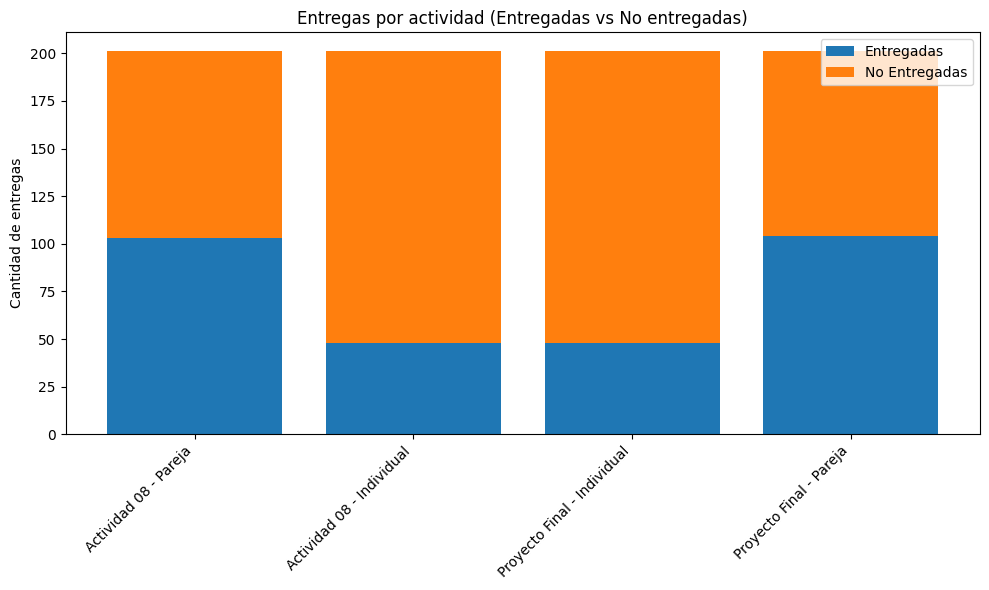

In [9]:

# Construcción automática de la tabla de resumen desde variables existentes
datos_resumen = [
    ["Actividad 08 - Pareja",            not_menosuno_pareja,     menosuno_pareja,     no_entregado_pareja,     entregado_pareja],
    ["Actividad 08 - Individual",        not_menosuno_individual, menosuno_individual, no_entregado_individual, entregado_individual],
    ["Proyecto Final - Individual",      not_menosuno_final_ind,  menosuno_final_ind,  no_entregado_final_ind,  entregado_final_ind],
    ["Proyecto Final - Pareja",          not_menosuno_final_par,  menosuno_final_par,  no_entregado_final_par,  entregado_final_par],
]

df_resumen = pd.DataFrame(datos_resumen, columns=[
    "Actividad",
    "Notas ≠ -1",
    "Notas = -1",
    "No Entregadas",
    "Entregadas"
])

display(df_resumen)

# Gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))

labels = df_resumen["Actividad"]
entregadas = df_resumen["Entregadas"]
no_entregadas = df_resumen["No Entregadas"]

ax.bar(labels, entregadas, label="Entregadas")
ax.bar(labels, no_entregadas, bottom=entregadas, label="No Entregadas")

ax.set_ylabel("Cantidad de entregas")
ax.set_title("Entregas por actividad (Entregadas vs No entregadas)")
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



## Calcular entregas de proyecto por usuario

In [29]:

# Definir listas de actividad
id_act_8 = [108640, 108641]
id_proyecto = [109226, 108047]

# Agregar por usuario si entregó algo en cada bloque
df_actividad_8 = df_entregas_tareas.filter(
    col("actividad_id").isin(id_act_8)
).groupBy("userid").agg(max("entregado").alias("entrego_act_8"))

df_actividad_proyecto = df_entregas_tareas.filter(
    col("actividad_id").isin(id_proyecto)
).groupBy("userid").agg(max("entregado").alias("entrego_proyecto"))

# Unir ambas comprobaciones
df_entregas_combinadas = df_actividad_8.join(
    df_actividad_proyecto, on="userid", how="outer"
).na.fill(0)


df_entregas_combinadas.show()

print("\nComprobaciones extra de entregas")
print("====================================")
# Ahora que ya tenemos concatenadas estas tareas con las tareas que se han hecho de ellas, podemos ver un repaso de cuantas entregas hubo para cada una 
entregas_por_tarea_diciembre = df_entregas_tareas.filter(col("actividad_id").isin(id_act_8)).groupBy("actividad_id", "actividad_nombre", "fecha_limite" ).agg(sparkSum("entregado").alias("num_entregas")).orderBy("num_entregas")
entregas_por_tarea_diciembre.show(truncate=False)

entregas_por_tarea_enero = df_entregas_tareas.filter(col("actividad_id").isin(id_proyecto)).groupBy("actividad_id", "actividad_nombre", "fecha_limite" ).agg(sparkSum("entregado").alias("num_entregas")).orderBy("num_entregas")
entregas_por_tarea_enero.show(truncate=False)

+--------------------+-------------+----------------+
|              userid|entrego_act_8|entrego_proyecto|
+--------------------+-------------+----------------+
|006b0e7bd07cec05e...|            1|               0|
|00ded60939d4949cc...|            1|               1|
|05912200993a87a89...|            0|               1|
|073b1d0ee1d3857d5...|            1|               1|
|080b2c8b65e9d941f...|            0|               0|
|091af124e119a447c...|            1|               1|
|0a2e27fd5eb3547b0...|            1|               1|
|11c0d56ee71665bfe...|            1|               1|
|13a777f8c88ba7482...|            1|               1|
|1416df0e4f8e87e44...|            1|               1|
|155bac00763fa5e9f...|            0|               0|
|178ba123e4d3f50b8...|            1|               1|
|17ab20c1e9ffc41ce...|            0|               1|
|17c5ff7d8da3431c1...|            1|               1|
|1c4901d900185d7d8...|            1|               1|
|1d1856f6484743138...|      

## Visualizar resultados obtenidos

,Categoría,Número de alumnos
0,Entregó ambas,135
1,Ninguna,33
2,Solo final,17
3,Solo actividad 8,16


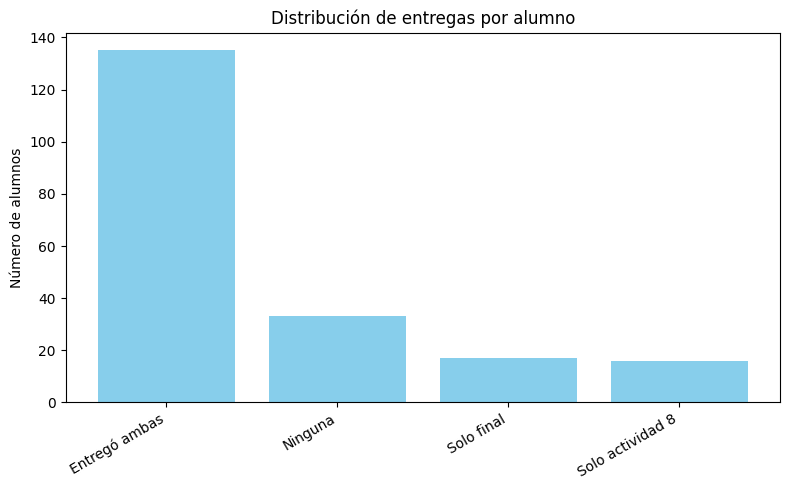

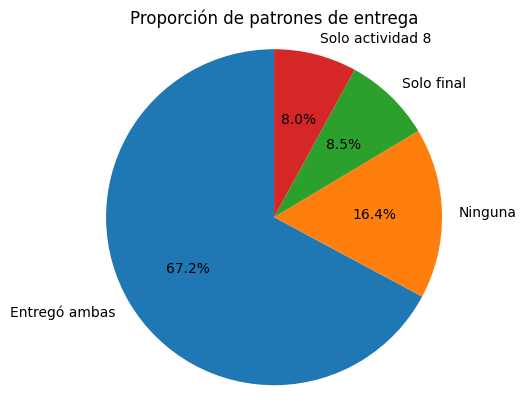

In [ ]:
df_local = df_entregas_combinadas.toPandas()

# Crear una categoría combinada
def categorizar(entrego_8, entrego_proy):
    if entrego_8 == 1 and entrego_proy == 1:
        return "Entregó ambas"
    elif entrego_8 == 1:
        return "Solo actividad 8"
    elif entrego_proy == 1:
        return "Solo final"
    else:
        return "Ninguna"

df_local["categoria_entregas"] = df_local.apply(
    lambda row: categorizar(row["entrego_act_8"], row["entrego_proyecto"]),
    axis=1
)

# Contar por categoría
resumen = df_local["categoria_entregas"].value_counts().reset_index()
resumen.columns = ["Categoría", "Número de alumnos"]

display(resumen)

# Gráfico de barras
fig, ax = plt.subplots(figsize=(8, 5))
plt.bar(resumen["Categoría"], resumen["Número de alumnos"], color="skyblue")
plt.title("Distribución de entregas por alumno")
plt.ylabel("Número de alumnos")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# Pie chart
fig, ax = plt.subplots()
ax.pie(resumen["Número de alumnos"], labels=resumen["Categoría"], autopct='%1.1f%%', startangle=90)
ax.axis("equal")  # Aspecto circular
plt.title("Proporción de patrones de entrega")
plt.show()



Por lo tanto, tras explorar la distribución de entregas en los usuarios del curso, evaluemos cuantos abandonos nos salían para cada una de estas dos reglas:

- Abandono si no entregó una, otra, o ninguna de las dos
- Abandono si no entregó ninguna de las dos
  

,Num_abandonos_fuerte,Num_abandonos_laxo
0,66,33


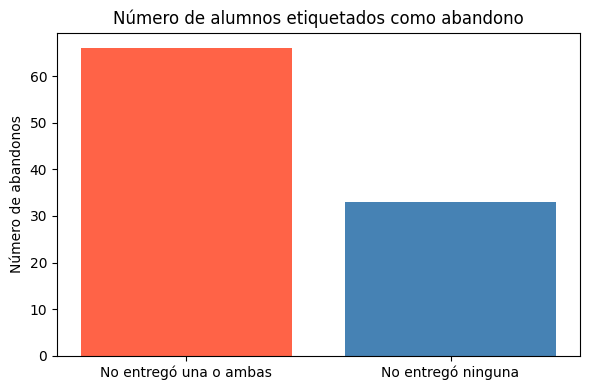

In [34]:

df_evaluacion = df_entregas_combinadas \
    .withColumn("abandona_regla1", when((col("entrego_act_8") == 0) | (col("entrego_proyecto") == 0), lit(1)).otherwise(lit(0))) \
    .withColumn("abandona_regla2", when((col("entrego_act_8") == 0) & (col("entrego_proyecto") == 0), lit(1)).otherwise(lit(0)))
    
resumen_abandono = df_evaluacion.groupBy().agg(
    sparkSum("abandona_regla1").alias("Num_abandonos_fuerte"),
    sparkSum("abandona_regla2").alias("Num_abandonos_laxo")
).toPandas()

display(resumen_abandono)



# Convertir a valores simples
valores = resumen_abandono.iloc[0]
labels = ["No entregó una o ambas", "No entregó ninguna"]
valores = [valores["Num_abandonos_fuerte"], valores["Num_abandonos_laxo"]]

# Gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(labels, valores, color=["tomato", "steelblue"])
plt.title("Número de alumnos etiquetados como abandono")
plt.ylabel("Número de abandonos")
plt.tight_layout()
plt.show()

